# Welcome to the second Grandest Soton NN test site

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchmetrics

In [19]:
# Choose parameters
size_batch = 1
learning_rate = 0.004
epochs = 200
early_stopping_patience = 13
scheduler_factor = 0.21
gpu_TF = False

# Load the data
FirstData = np.load("equal_data_high_otype.npy", allow_pickle=True)

# Check for GPU
if gpu_TF:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Running on ", device)
else:
    device = torch.device('cpu')
    print("Running on CPU")

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=size_batch, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
early_stopping = EarlyStopping(patience = early_stopping_patience, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Running on CPU


Epoch 1/200: 100%|██████████| 10553/10553 [00:32<00:00, 322.73batch/s, Loss=0.8539]



Validation Loss after Epoch 1: 0.7969
Test Accuracy after Epoch 1: 0.6794


Epoch 2/200: 100%|██████████| 10553/10553 [00:31<00:00, 333.85batch/s, Loss=0.7563]



Validation Loss after Epoch 2: 0.7658
Test Accuracy after Epoch 2: 0.6848


Epoch 3/200: 100%|██████████| 10553/10553 [00:32<00:00, 323.31batch/s, Loss=0.7168]



Validation Loss after Epoch 3: 0.6477
Test Accuracy after Epoch 3: 0.7476


Epoch 4/200: 100%|██████████| 10553/10553 [00:33<00:00, 311.43batch/s, Loss=0.7015]



Validation Loss after Epoch 4: 0.6765
Test Accuracy after Epoch 4: 0.6970


Epoch 5/200: 100%|██████████| 10553/10553 [00:31<00:00, 332.54batch/s, Loss=0.6814]



Validation Loss after Epoch 5: 0.6792
Test Accuracy after Epoch 5: 0.7098


Epoch 6/200: 100%|██████████| 10553/10553 [00:33<00:00, 312.70batch/s, Loss=0.6752]



Validation Loss after Epoch 6: 0.6992
Test Accuracy after Epoch 6: 0.7084


Epoch 7/200: 100%|██████████| 10553/10553 [00:33<00:00, 316.03batch/s, Loss=0.6740]



Validation Loss after Epoch 7: 0.6652
Test Accuracy after Epoch 7: 0.7362


Epoch 8/200: 100%|██████████| 10553/10553 [00:32<00:00, 325.29batch/s, Loss=0.5665]



Validation Loss after Epoch 8: 0.5506
Test Accuracy after Epoch 8: 0.7931


Epoch 9/200: 100%|██████████| 10553/10553 [00:34<00:00, 308.73batch/s, Loss=0.5452]



Validation Loss after Epoch 9: 0.5332
Test Accuracy after Epoch 9: 0.7936


Epoch 10/200: 100%|██████████| 10553/10553 [00:33<00:00, 316.44batch/s, Loss=0.5347]



Validation Loss after Epoch 10: 0.5302
Test Accuracy after Epoch 10: 0.7948


Epoch 11/200: 100%|██████████| 10553/10553 [00:33<00:00, 318.43batch/s, Loss=0.5288]



Validation Loss after Epoch 11: 0.5270
Test Accuracy after Epoch 11: 0.7891


Epoch 12/200: 100%|██████████| 10553/10553 [00:34<00:00, 305.36batch/s, Loss=0.5231]



Validation Loss after Epoch 12: 0.5340
Test Accuracy after Epoch 12: 0.7891


Epoch 13/200: 100%|██████████| 10553/10553 [00:33<00:00, 318.37batch/s, Loss=0.5182]



Validation Loss after Epoch 13: 0.5063
Test Accuracy after Epoch 13: 0.8059


Epoch 14/200: 100%|██████████| 10553/10553 [00:34<00:00, 309.37batch/s, Loss=0.5182]



Validation Loss after Epoch 14: 0.5140
Test Accuracy after Epoch 14: 0.7951


Epoch 15/200: 100%|██████████| 10553/10553 [00:34<00:00, 308.25batch/s, Loss=0.5115]



Validation Loss after Epoch 15: 0.5402
Test Accuracy after Epoch 15: 0.7874


Epoch 16/200: 100%|██████████| 10553/10553 [00:34<00:00, 302.15batch/s, Loss=0.5132]



Validation Loss after Epoch 16: 0.5051
Test Accuracy after Epoch 16: 0.8019


Epoch 17/200: 100%|██████████| 10553/10553 [00:37<00:00, 280.10batch/s, Loss=0.5116]



Validation Loss after Epoch 17: 0.5101
Test Accuracy after Epoch 17: 0.8036


Epoch 18/200: 100%|██████████| 10553/10553 [00:33<00:00, 313.19batch/s, Loss=0.5053]



Validation Loss after Epoch 18: 0.5657
Test Accuracy after Epoch 18: 0.7769


Epoch 19/200: 100%|██████████| 10553/10553 [00:31<00:00, 340.31batch/s, Loss=0.5069]



Validation Loss after Epoch 19: 0.5062
Test Accuracy after Epoch 19: 0.8059


Epoch 20/200: 100%|██████████| 10553/10553 [00:33<00:00, 317.74batch/s, Loss=0.5070]



Validation Loss after Epoch 20: 0.5197
Test Accuracy after Epoch 20: 0.7936


Epoch 21/200: 100%|██████████| 10553/10553 [00:33<00:00, 317.16batch/s, Loss=0.4582]



Validation Loss after Epoch 21: 0.4778
Test Accuracy after Epoch 21: 0.8135


Epoch 22/200: 100%|██████████| 10553/10553 [00:31<00:00, 338.40batch/s, Loss=0.4454]



Validation Loss after Epoch 22: 0.4743
Test Accuracy after Epoch 22: 0.8184


Epoch 23/200: 100%|██████████| 10553/10553 [00:33<00:00, 316.53batch/s, Loss=0.4424]



Validation Loss after Epoch 23: 0.4722
Test Accuracy after Epoch 23: 0.8172


Epoch 24/200: 100%|██████████| 10553/10553 [00:33<00:00, 319.12batch/s, Loss=0.4400]



Validation Loss after Epoch 24: 0.4765
Test Accuracy after Epoch 24: 0.8181


Epoch 25/200: 100%|██████████| 10553/10553 [00:31<00:00, 331.99batch/s, Loss=0.4377]



Validation Loss after Epoch 25: 0.4690
Test Accuracy after Epoch 25: 0.8198


Epoch 26/200: 100%|██████████| 10553/10553 [00:33<00:00, 314.11batch/s, Loss=0.4353]



Validation Loss after Epoch 26: 0.4677
Test Accuracy after Epoch 26: 0.8198


Epoch 27/200: 100%|██████████| 10553/10553 [00:32<00:00, 325.59batch/s, Loss=0.4339]



Validation Loss after Epoch 27: 0.4701
Test Accuracy after Epoch 27: 0.8169


Epoch 28/200: 100%|██████████| 10553/10553 [00:32<00:00, 327.06batch/s, Loss=0.4332]



Validation Loss after Epoch 28: 0.4672
Test Accuracy after Epoch 28: 0.8186


Epoch 29/200: 100%|██████████| 10553/10553 [00:33<00:00, 315.40batch/s, Loss=0.4297]



Validation Loss after Epoch 29: 0.4847
Test Accuracy after Epoch 29: 0.8104


Epoch 30/200: 100%|██████████| 10553/10553 [00:32<00:00, 324.98batch/s, Loss=0.4302]



Validation Loss after Epoch 30: 0.4824
Test Accuracy after Epoch 30: 0.8135


Epoch 31/200: 100%|██████████| 10553/10553 [00:32<00:00, 327.90batch/s, Loss=0.4282]



Validation Loss after Epoch 31: 0.4712
Test Accuracy after Epoch 31: 0.8204


Epoch 32/200: 100%|██████████| 10553/10553 [00:33<00:00, 313.13batch/s, Loss=0.4267]



Validation Loss after Epoch 32: 0.4711
Test Accuracy after Epoch 32: 0.8167


Epoch 33/200: 100%|██████████| 10553/10553 [00:31<00:00, 331.59batch/s, Loss=0.4122]



Validation Loss after Epoch 33: 0.4619
Test Accuracy after Epoch 33: 0.8198


Epoch 34/200: 100%|██████████| 10553/10553 [00:32<00:00, 320.50batch/s, Loss=0.4104]



Validation Loss after Epoch 34: 0.4644
Test Accuracy after Epoch 34: 0.8209


Epoch 35/200: 100%|██████████| 10553/10553 [00:33<00:00, 317.16batch/s, Loss=0.4092]



Validation Loss after Epoch 35: 0.4611
Test Accuracy after Epoch 35: 0.8215


Epoch 36/200: 100%|██████████| 10553/10553 [00:31<00:00, 338.06batch/s, Loss=0.4089]



Validation Loss after Epoch 36: 0.4654
Test Accuracy after Epoch 36: 0.8218


Epoch 37/200: 100%|██████████| 10553/10553 [00:33<00:00, 319.47batch/s, Loss=0.4083]



Validation Loss after Epoch 37: 0.4653
Test Accuracy after Epoch 37: 0.8226


Epoch 38/200: 100%|██████████| 10553/10553 [00:33<00:00, 313.04batch/s, Loss=0.4073]



Validation Loss after Epoch 38: 0.4644
Test Accuracy after Epoch 38: 0.8218


Epoch 39/200: 100%|██████████| 10553/10553 [00:30<00:00, 344.08batch/s, Loss=0.4068]



Validation Loss after Epoch 39: 0.4632
Test Accuracy after Epoch 39: 0.8221


Epoch 40/200: 100%|██████████| 10553/10553 [00:33<00:00, 316.05batch/s, Loss=0.4034]



Validation Loss after Epoch 40: 0.4631
Test Accuracy after Epoch 40: 0.8209


Epoch 41/200: 100%|██████████| 10553/10553 [00:34<00:00, 306.99batch/s, Loss=0.4027]



Validation Loss after Epoch 41: 0.4634
Test Accuracy after Epoch 41: 0.8215


Epoch 42/200: 100%|██████████| 10553/10553 [00:30<00:00, 341.39batch/s, Loss=0.4026]



Validation Loss after Epoch 42: 0.4639
Test Accuracy after Epoch 42: 0.8229


Epoch 43/200: 100%|██████████| 10553/10553 [00:33<00:00, 315.59batch/s, Loss=0.4023]



Validation Loss after Epoch 43: 0.4636
Test Accuracy after Epoch 43: 0.8218


Epoch 44/200: 100%|██████████| 10553/10553 [00:34<00:00, 310.19batch/s, Loss=0.4012]



Validation Loss after Epoch 44: 0.4634
Test Accuracy after Epoch 44: 0.8215


Epoch 45/200: 100%|██████████| 10553/10553 [00:30<00:00, 341.36batch/s, Loss=0.4012]



Validation Loss after Epoch 45: 0.4636
Test Accuracy after Epoch 45: 0.8215


Epoch 46/200: 100%|██████████| 10553/10553 [00:33<00:00, 315.40batch/s, Loss=0.4011]



Validation Loss after Epoch 46: 0.4638
Early stopping


Classification Report:
               precision    recall  f1-score   support

         AGN       0.78      0.87      0.82       724
         BIN       0.83      0.83      0.83       935
         GAL       0.84      0.77      0.81       968
        STAR       0.82      0.82      0.82       891

    accuracy                           0.82      3518
   macro avg       0.82      0.82      0.82      3518
weighted avg       0.82      0.82      0.82      3518



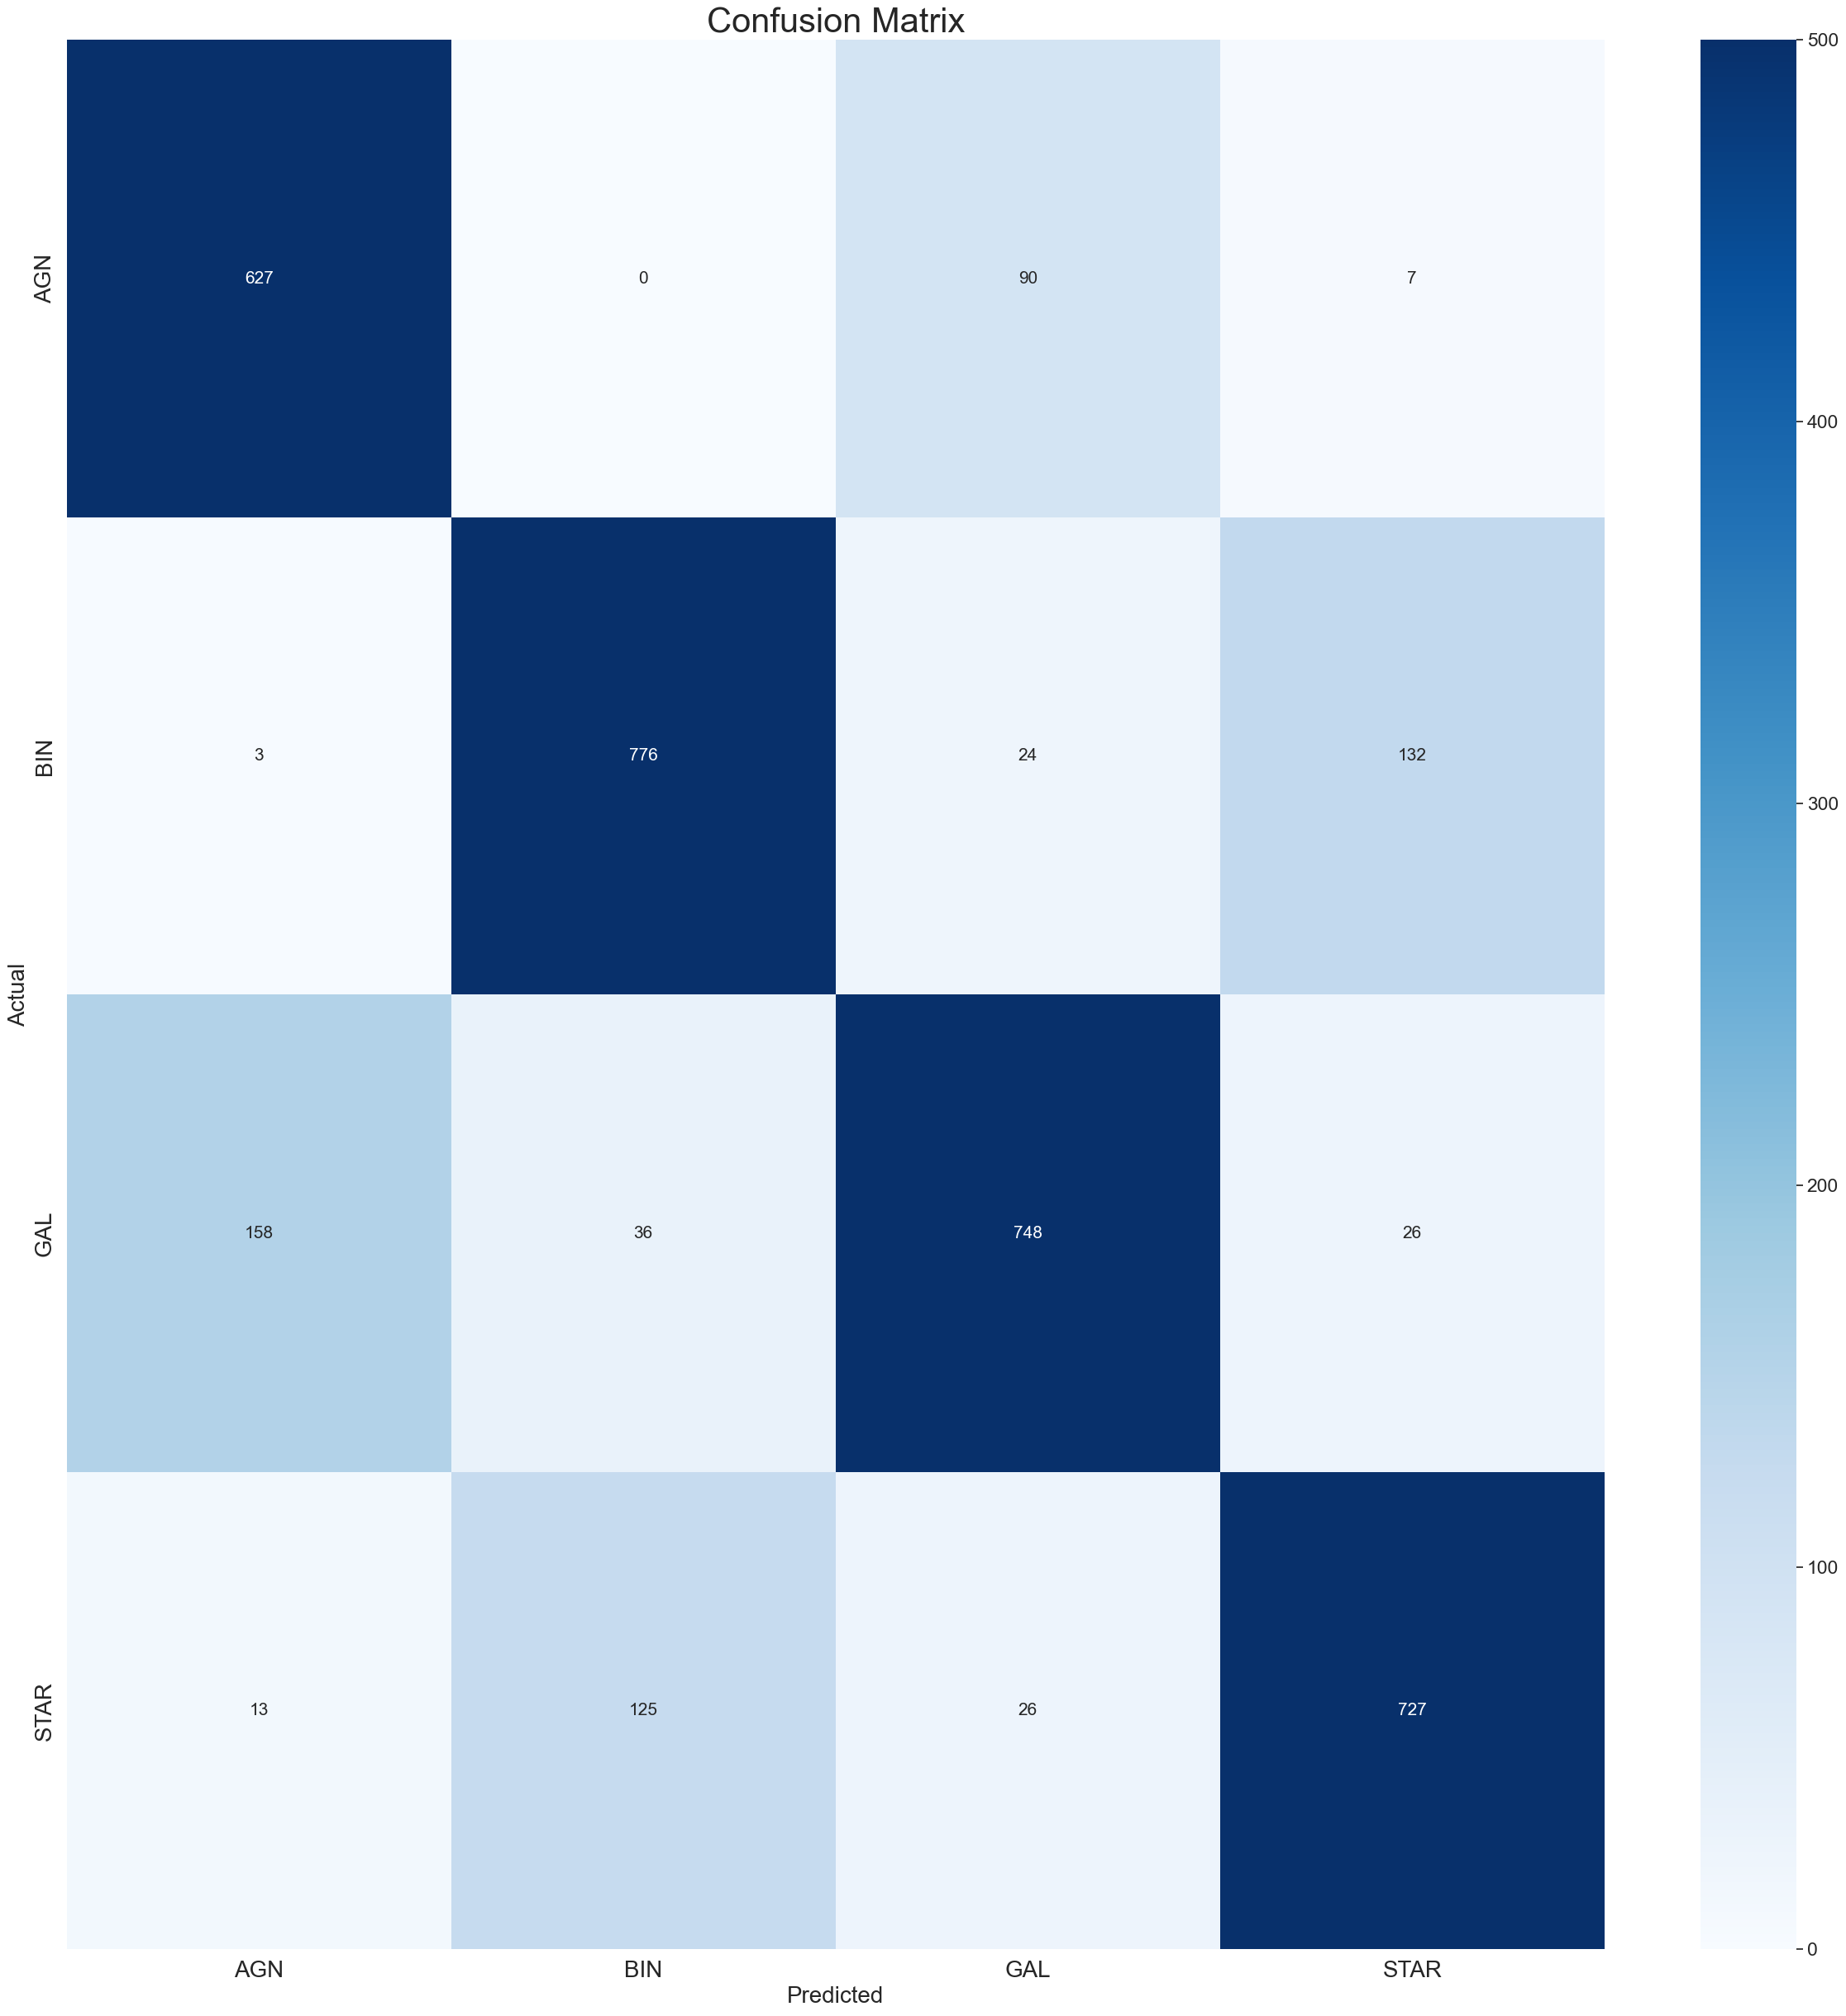

In [13]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=500, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()


# chatgpt improved

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm
import torchmetrics

# Parameters
size_batch = 256
learning_rate = 0.004
epochs = 100
early_stopping_patience = 8
scheduler_factor = 0.21
gpu_TF = False

# Check for GPU
if gpu_TF:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Running on ", device)
else:
    device = torch.device('cpu')
    print("Running on CPU")
    
# Load the data
FirstData = np.load("equal_data_high_otype.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create DataLoader with pin_memory for faster data transfer to GPU
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=size_batch, shuffle=True, pin_memory=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=size_batch, shuffle=False, pin_memory=True)

# Define the neural network with Dropout for regularization
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(y))
model = NeuralNetwork(input_size, output_size).to(device)

# Calculate class weights and define loss function
class_counts = np.bincount(y_train_tensor.cpu().numpy())
class_weights = torch.tensor([len(y_train) / count for count in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use AdamW optimizer and learning rate scheduler
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=3, verbose=True)

# Early stopping with model checkpointing
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, checkpoint_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.checkpoint_path)

# Training with mixed precision
scaler = torch.cuda.amp.GradScaler()

# Function to calculate accuracy using torchmetrics
accuracy_metric = torchmetrics.Accuracy().to(device)

def calculate_accuracy(loader, model):
    model.eval()
    accuracy = torchmetrics.Accuracy().to(device)
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            accuracy.update(predicted, y_batch)
    return accuracy.compute().item()

# Training loop with early stopping and mixed precision
early_stopping = EarlyStopping(patience=early_stopping_patience)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)

    # Print validation loss
    print(f'Validation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print test accuracy
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')

# Load the best model after early stopping
model.load_state_dict(torch.load("best_model.pth"))


Running on CPU


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\jcwin\AppData\Local\Temp\ipykernel_28248\2849015572.py:117: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


TypeError: Accuracy.__new__() missing 1 required positional argument: 'task'

# no gal

In [5]:
# Choose parameters
size_batch = 256
learning_rate = 0.004
epochs = 100
early_stopping_patience = 12
scheduler_factor = 0.21
scheduler_patience = 5
classweightmax = 10000
gpu_TF = False

# Check for GPU
if gpu_TF:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Running on ", device)
else:
    device = torch.device('cpu')
    print("Running on CPU")

# Load the data
FirstData = np.load("no_gal_high_otype.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=size_batch, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 40)
        self.fc2 = nn.Linear(40, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
print("Class Weights: ", class_weights)
class_weights = torch.tensor(np.clip(class_weights, 0, classweightmax), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
early_stopping = EarlyStopping(patience = early_stopping_patience, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on CPU


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class Weights:  [3.0017783996089205, 2.998795931427032, 2.999427315372371]


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.51batch/s, Loss=0.3144]



Validation Loss after Epoch 1: 0.2591
Test Accuracy after Epoch 1: 0.8955


Epoch 2/100: 100%|██████████| 2783/2783 [00:18<00:00, 150.41batch/s, Loss=0.2453]



Validation Loss after Epoch 2: 0.2308
Test Accuracy after Epoch 2: 0.9100


Epoch 3/100: 100%|██████████| 2783/2783 [00:17<00:00, 157.02batch/s, Loss=0.2287]



Validation Loss after Epoch 3: 0.2225
Test Accuracy after Epoch 3: 0.9144


Epoch 4/100: 100%|██████████| 2783/2783 [00:18<00:00, 146.57batch/s, Loss=0.2236]



Validation Loss after Epoch 4: 0.2178
Test Accuracy after Epoch 4: 0.9161


Epoch 5/100: 100%|██████████| 2783/2783 [00:19<00:00, 141.41batch/s, Loss=0.2173]



Validation Loss after Epoch 5: 0.2183
Test Accuracy after Epoch 5: 0.9139


Epoch 6/100: 100%|██████████| 2783/2783 [00:18<00:00, 148.12batch/s, Loss=0.2145]



Validation Loss after Epoch 6: 0.2191
Test Accuracy after Epoch 6: 0.9153


Epoch 7/100: 100%|██████████| 2783/2783 [00:17<00:00, 158.72batch/s, Loss=0.2149]



Validation Loss after Epoch 7: 0.2115
Test Accuracy after Epoch 7: 0.9195


Epoch 8/100: 100%|██████████| 2783/2783 [00:18<00:00, 146.96batch/s, Loss=0.2109]



Validation Loss after Epoch 8: 0.2085
Test Accuracy after Epoch 8: 0.9185


Epoch 9/100: 100%|██████████| 2783/2783 [00:18<00:00, 147.57batch/s, Loss=0.2092]



Validation Loss after Epoch 9: 0.2132
Test Accuracy after Epoch 9: 0.9181


Epoch 10/100: 100%|██████████| 2783/2783 [00:21<00:00, 130.67batch/s, Loss=0.2079]



Validation Loss after Epoch 10: 0.2096
Test Accuracy after Epoch 10: 0.9183


Epoch 11/100: 100%|██████████| 2783/2783 [00:17<00:00, 154.86batch/s, Loss=0.2072]



Validation Loss after Epoch 11: 0.2043
Test Accuracy after Epoch 11: 0.9206


Epoch 12/100: 100%|██████████| 2783/2783 [00:32<00:00, 85.66batch/s, Loss=0.2057] 



Validation Loss after Epoch 12: 0.2043
Test Accuracy after Epoch 12: 0.9196


Epoch 13/100: 100%|██████████| 2783/2783 [00:28<00:00, 98.12batch/s, Loss=0.2042] 



Validation Loss after Epoch 13: 0.2105
Test Accuracy after Epoch 13: 0.9179


Epoch 14/100: 100%|██████████| 2783/2783 [00:24<00:00, 111.60batch/s, Loss=0.2049]



Validation Loss after Epoch 14: 0.2169
Test Accuracy after Epoch 14: 0.9167


Epoch 15/100: 100%|██████████| 2783/2783 [00:19<00:00, 140.13batch/s, Loss=0.2053]



Validation Loss after Epoch 15: 0.2074
Test Accuracy after Epoch 15: 0.9199


Epoch 16/100: 100%|██████████| 2783/2783 [00:23<00:00, 119.55batch/s, Loss=0.2037]



Validation Loss after Epoch 16: 0.2048
Test Accuracy after Epoch 16: 0.9208


Epoch 17/100: 100%|██████████| 2783/2783 [00:21<00:00, 128.53batch/s, Loss=0.2036]



Validation Loss after Epoch 17: 0.2041
Test Accuracy after Epoch 17: 0.9211


Epoch 18/100: 100%|██████████| 2783/2783 [00:20<00:00, 135.45batch/s, Loss=0.2031]



Validation Loss after Epoch 18: 0.2028
Test Accuracy after Epoch 18: 0.9207


Epoch 19/100: 100%|██████████| 2783/2783 [00:18<00:00, 148.35batch/s, Loss=0.2040]



Validation Loss after Epoch 19: 0.2080
Test Accuracy after Epoch 19: 0.9173


Epoch 20/100: 100%|██████████| 2783/2783 [00:20<00:00, 134.35batch/s, Loss=0.2031]



Validation Loss after Epoch 20: 0.2336
Test Accuracy after Epoch 20: 0.9072


Epoch 21/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.69batch/s, Loss=0.2032]



Validation Loss after Epoch 21: 0.2073
Test Accuracy after Epoch 21: 0.9188


Epoch 22/100: 100%|██████████| 2783/2783 [00:18<00:00, 149.43batch/s, Loss=0.2033]



Validation Loss after Epoch 22: 0.2058
Test Accuracy after Epoch 22: 0.9188


Epoch 23/100: 100%|██████████| 2783/2783 [00:18<00:00, 152.92batch/s, Loss=0.2021]



Validation Loss after Epoch 23: 0.2120
Test Accuracy after Epoch 23: 0.9176


Epoch 24/100: 100%|██████████| 2783/2783 [00:19<00:00, 143.01batch/s, Loss=0.2023]



Validation Loss after Epoch 24: 0.2347
Test Accuracy after Epoch 24: 0.9059


Epoch 25/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.09batch/s, Loss=0.1818]



Validation Loss after Epoch 25: 0.1849
Test Accuracy after Epoch 25: 0.9283


Epoch 26/100: 100%|██████████| 2783/2783 [00:18<00:00, 146.73batch/s, Loss=0.1788]



Validation Loss after Epoch 26: 0.1821
Test Accuracy after Epoch 26: 0.9295


Epoch 27/100: 100%|██████████| 2783/2783 [00:18<00:00, 153.27batch/s, Loss=0.1771]



Validation Loss after Epoch 27: 0.1810
Test Accuracy after Epoch 27: 0.9306


Epoch 28/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.51batch/s, Loss=0.1765]



Validation Loss after Epoch 28: 0.1802
Test Accuracy after Epoch 28: 0.9306


Epoch 29/100: 100%|██████████| 2783/2783 [00:19<00:00, 145.78batch/s, Loss=0.1756]



Validation Loss after Epoch 29: 0.1815
Test Accuracy after Epoch 29: 0.9297


Epoch 30/100: 100%|██████████| 2783/2783 [00:18<00:00, 151.29batch/s, Loss=0.1752]



Validation Loss after Epoch 30: 0.1825
Test Accuracy after Epoch 30: 0.9289


Epoch 31/100: 100%|██████████| 2783/2783 [00:19<00:00, 145.56batch/s, Loss=0.1750]



Validation Loss after Epoch 31: 0.1811
Test Accuracy after Epoch 31: 0.9297


Epoch 32/100: 100%|██████████| 2783/2783 [00:19<00:00, 139.79batch/s, Loss=0.1741]



Validation Loss after Epoch 32: 0.1820
Test Accuracy after Epoch 32: 0.9296


Epoch 33/100: 100%|██████████| 2783/2783 [00:21<00:00, 132.35batch/s, Loss=0.1742]



Validation Loss after Epoch 33: 0.1782
Test Accuracy after Epoch 33: 0.9310


Epoch 34/100: 100%|██████████| 2783/2783 [00:21<00:00, 132.08batch/s, Loss=0.1741]



Validation Loss after Epoch 34: 0.1914
Test Accuracy after Epoch 34: 0.9249


Epoch 35/100: 100%|██████████| 2783/2783 [00:18<00:00, 146.84batch/s, Loss=0.1739]



Validation Loss after Epoch 35: 0.1778
Test Accuracy after Epoch 35: 0.9311


Epoch 36/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.51batch/s, Loss=0.1737]



Validation Loss after Epoch 36: 0.1778
Test Accuracy after Epoch 36: 0.9316


Epoch 37/100: 100%|██████████| 2783/2783 [00:20<00:00, 133.78batch/s, Loss=0.1737]



Validation Loss after Epoch 37: 0.1796
Test Accuracy after Epoch 37: 0.9307


Epoch 38/100: 100%|██████████| 2783/2783 [00:20<00:00, 139.06batch/s, Loss=0.1728]



Validation Loss after Epoch 38: 0.1867
Test Accuracy after Epoch 38: 0.9266


Epoch 39/100: 100%|██████████| 2783/2783 [00:20<00:00, 136.15batch/s, Loss=0.1734]



Validation Loss after Epoch 39: 0.1829
Test Accuracy after Epoch 39: 0.9291


Epoch 40/100: 100%|██████████| 2783/2783 [00:20<00:00, 132.60batch/s, Loss=0.1732]



Validation Loss after Epoch 40: 0.1787
Test Accuracy after Epoch 40: 0.9307


Epoch 41/100: 100%|██████████| 2783/2783 [00:20<00:00, 136.87batch/s, Loss=0.1733]



Validation Loss after Epoch 41: 0.1887
Test Accuracy after Epoch 41: 0.9259


Epoch 42/100: 100%|██████████| 2783/2783 [00:18<00:00, 154.27batch/s, Loss=0.1730]



Validation Loss after Epoch 42: 0.1758
Test Accuracy after Epoch 42: 0.9321


Epoch 43/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.65batch/s, Loss=0.1729]



Validation Loss after Epoch 43: 0.1825
Test Accuracy after Epoch 43: 0.9295


Epoch 44/100: 100%|██████████| 2783/2783 [00:20<00:00, 133.58batch/s, Loss=0.1728]



Validation Loss after Epoch 44: 0.1785
Test Accuracy after Epoch 44: 0.9310


Epoch 45/100: 100%|██████████| 2783/2783 [00:19<00:00, 143.06batch/s, Loss=0.1730]



Validation Loss after Epoch 45: 0.1796
Test Accuracy after Epoch 45: 0.9298


Epoch 46/100: 100%|██████████| 2783/2783 [00:18<00:00, 149.34batch/s, Loss=0.1730]



Validation Loss after Epoch 46: 0.1806
Test Accuracy after Epoch 46: 0.9304


Epoch 47/100: 100%|██████████| 2783/2783 [00:20<00:00, 137.26batch/s, Loss=0.1725]



Validation Loss after Epoch 47: 0.1770
Test Accuracy after Epoch 47: 0.9313


Epoch 48/100: 100%|██████████| 2783/2783 [00:20<00:00, 138.11batch/s, Loss=0.1727]



Validation Loss after Epoch 48: 0.1808
Test Accuracy after Epoch 48: 0.9298


Epoch 49/100: 100%|██████████| 2783/2783 [00:19<00:00, 142.56batch/s, Loss=0.1644]



Validation Loss after Epoch 49: 0.1729
Test Accuracy after Epoch 49: 0.9331


Epoch 50/100: 100%|██████████| 2783/2783 [00:19<00:00, 144.31batch/s, Loss=0.1635]



Validation Loss after Epoch 50: 0.1708
Test Accuracy after Epoch 50: 0.9341


Epoch 51/100: 100%|██████████| 2783/2783 [00:18<00:00, 149.24batch/s, Loss=0.1630]



Validation Loss after Epoch 51: 0.1713
Test Accuracy after Epoch 51: 0.9341


Epoch 52/100: 100%|██████████| 2783/2783 [00:19<00:00, 145.50batch/s, Loss=0.1626]



Validation Loss after Epoch 52: 0.1708
Test Accuracy after Epoch 52: 0.9342


Epoch 53/100: 100%|██████████| 2783/2783 [00:19<00:00, 143.55batch/s, Loss=0.1624]



Validation Loss after Epoch 53: 0.1716
Test Accuracy after Epoch 53: 0.9340


Epoch 54/100: 100%|██████████| 2783/2783 [00:19<00:00, 146.25batch/s, Loss=0.1621]



Validation Loss after Epoch 54: 0.1712
Test Accuracy after Epoch 54: 0.9340


Epoch 55/100: 100%|██████████| 2783/2783 [00:19<00:00, 141.99batch/s, Loss=0.1621]



Validation Loss after Epoch 55: 0.1708
Test Accuracy after Epoch 55: 0.9344


Epoch 56/100: 100%|██████████| 2783/2783 [00:19<00:00, 141.61batch/s, Loss=0.1618]



Validation Loss after Epoch 56: 0.1707
Test Accuracy after Epoch 56: 0.9343


Epoch 57/100: 100%|██████████| 2783/2783 [00:19<00:00, 142.91batch/s, Loss=0.1617]



Validation Loss after Epoch 57: 0.1707
Test Accuracy after Epoch 57: 0.9345


Epoch 58/100: 100%|██████████| 2783/2783 [00:18<00:00, 146.52batch/s, Loss=0.1616]



Validation Loss after Epoch 58: 0.1732
Test Accuracy after Epoch 58: 0.9334


Epoch 59/100: 100%|██████████| 2783/2783 [00:19<00:00, 145.92batch/s, Loss=0.1614]



Validation Loss after Epoch 59: 0.1702
Test Accuracy after Epoch 59: 0.9347


Epoch 60/100: 100%|██████████| 2783/2783 [00:19<00:00, 145.95batch/s, Loss=0.1614]



Validation Loss after Epoch 60: 0.1713
Test Accuracy after Epoch 60: 0.9341


Epoch 61/100: 100%|██████████| 2783/2783 [00:18<00:00, 147.51batch/s, Loss=0.1612]



Validation Loss after Epoch 61: 0.1724
Test Accuracy after Epoch 61: 0.9337


Epoch 62/100: 100%|██████████| 2783/2783 [00:17<00:00, 155.77batch/s, Loss=0.1610]



Validation Loss after Epoch 62: 0.1719
Early stopping


Classification Report:
               precision    recall  f1-score   support

         AGN       0.99      0.99      0.99     79285
         BIN       0.89      0.92      0.91     79049
        STAR       0.92      0.88      0.90     79099

    accuracy                           0.93    237433
   macro avg       0.93      0.93      0.93    237433
weighted avg       0.93      0.93      0.93    237433



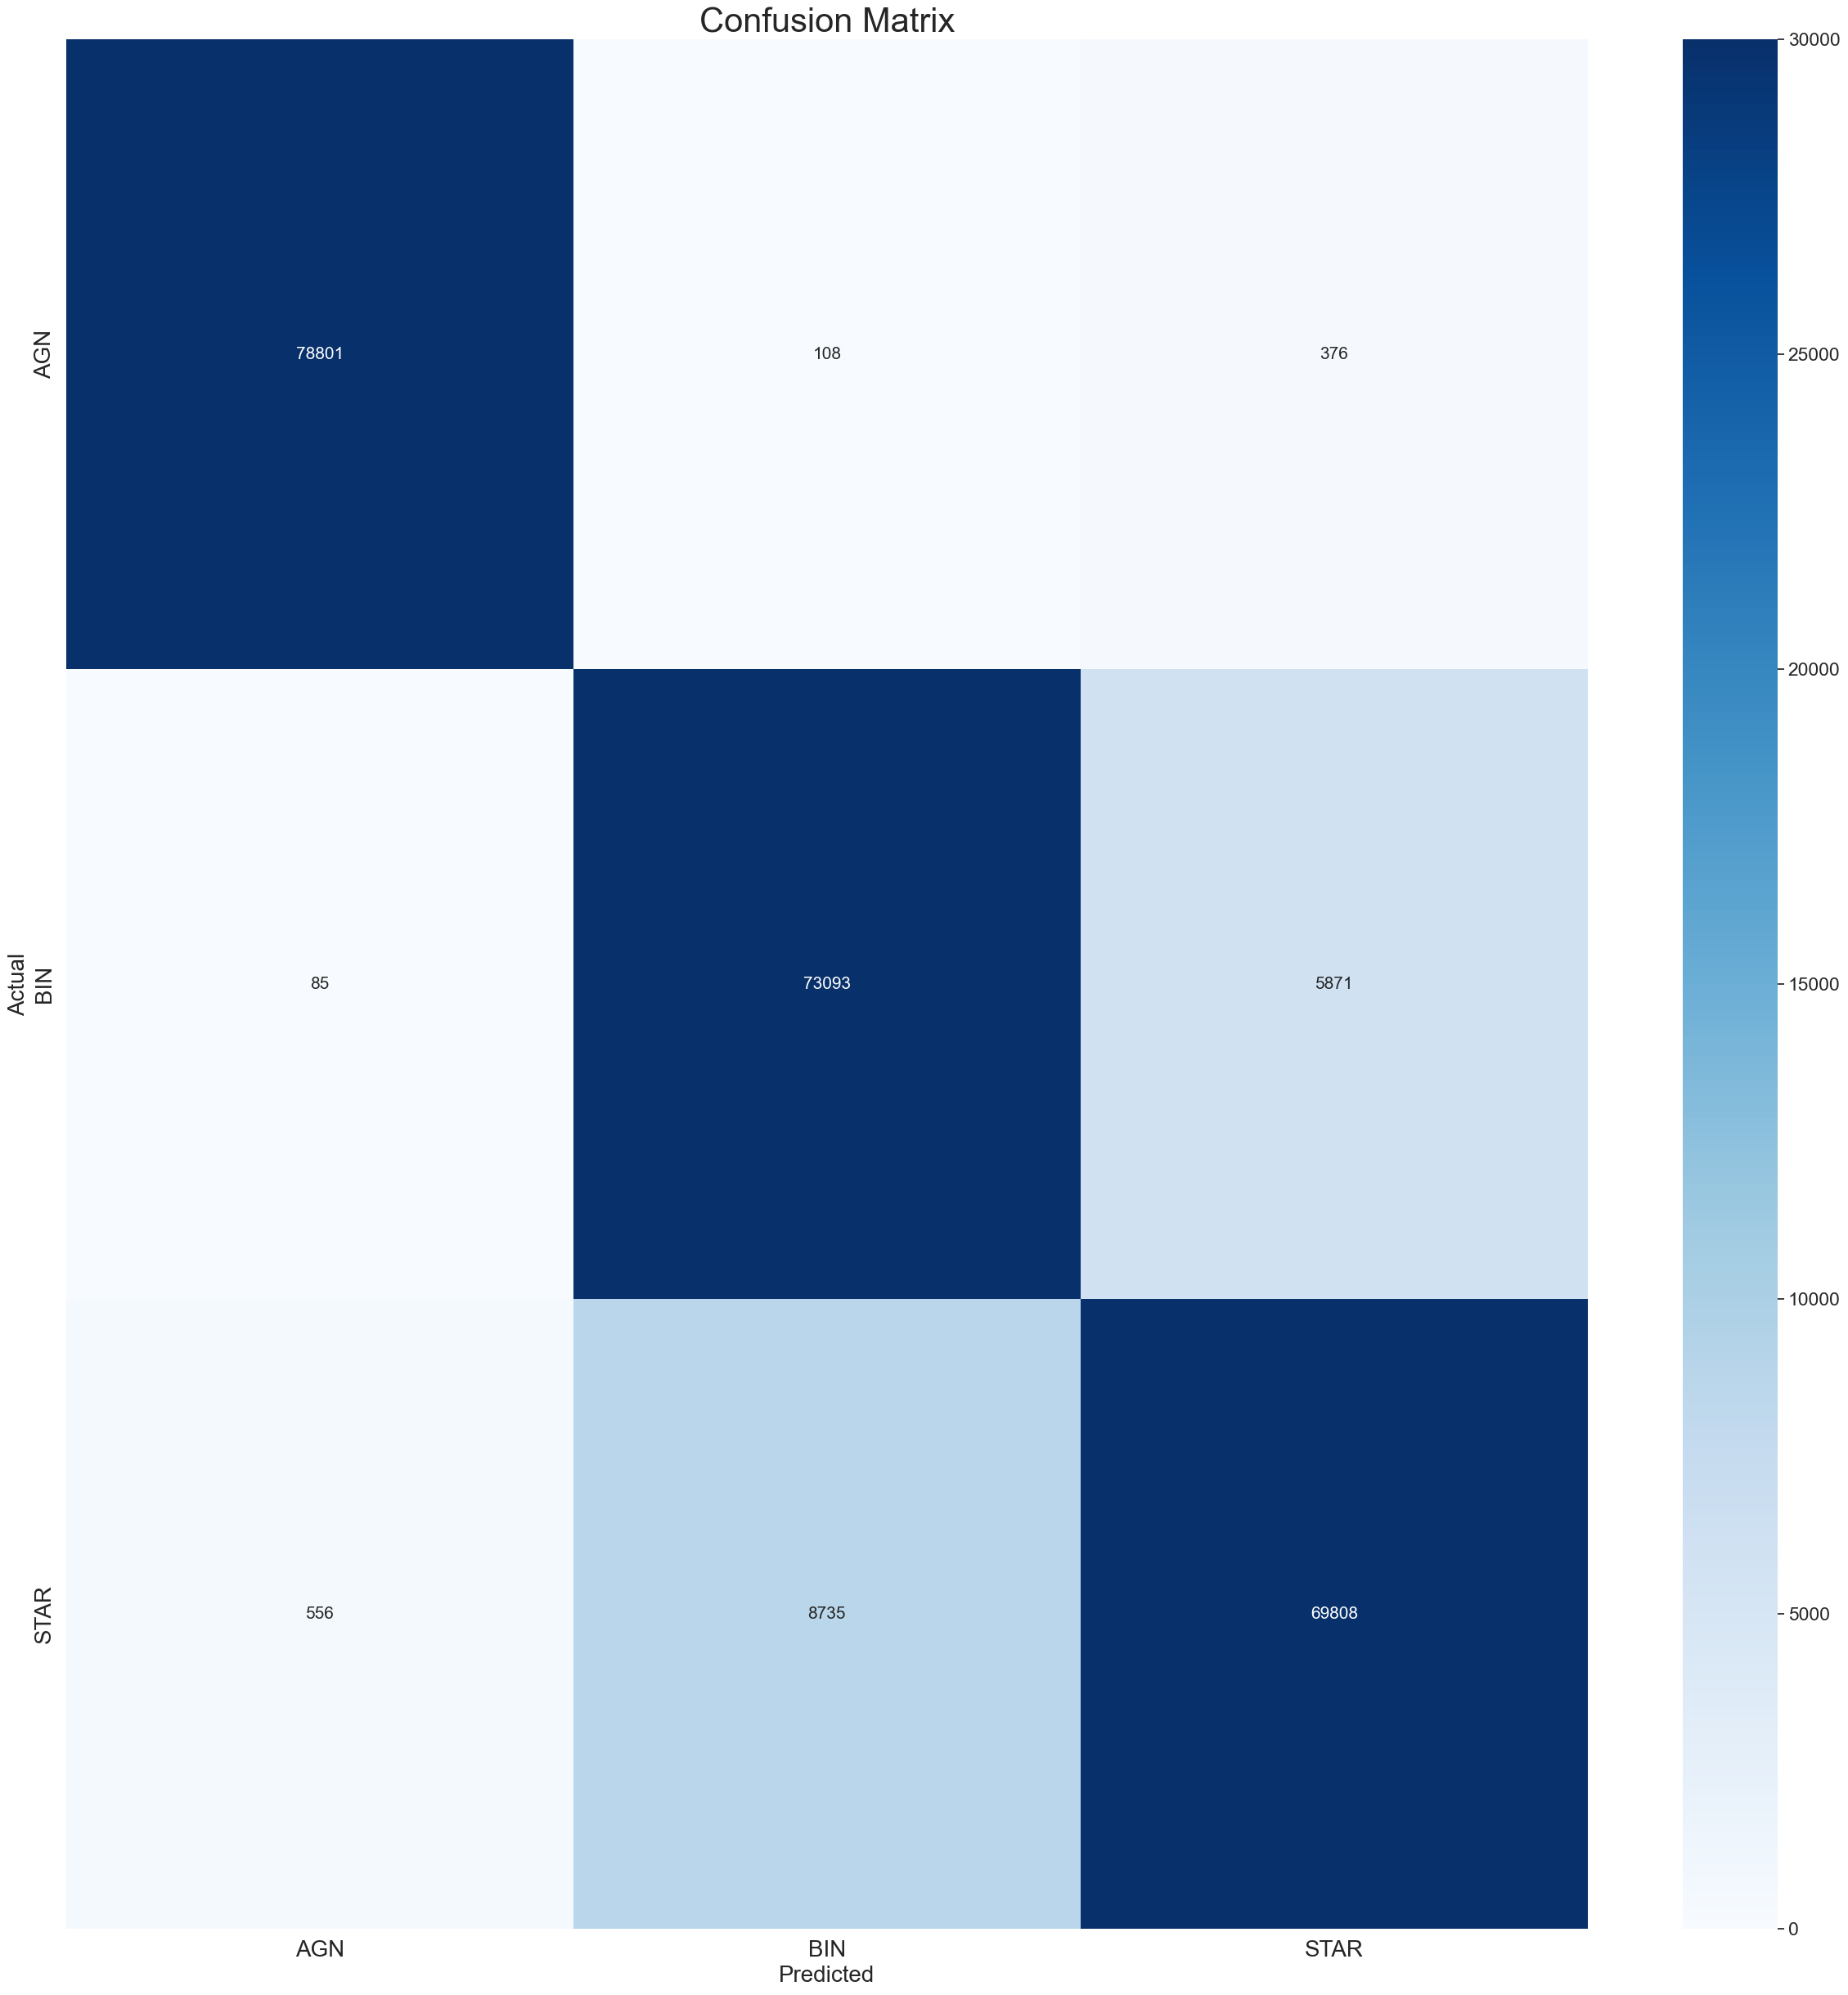

In [11]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=30000, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
